In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from read_data import create_df, create_dfV2, create_df_old, tic, toc
import numpy as np

pd.set_option('display.max_rows', 1000)

# Generic plotting configurations
plt.rcParams['figure.figsize'] = [10, 8]
plt.style.use('ggplot')

In [4]:
# Select which experiments to plot
EXP = 'G9'
NREP = [1]
NROB = [8]

# Collect data
df = create_df(EXP, 'sc')

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/42/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/28/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/24/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/66/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/17/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/32/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/44/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/49/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/8/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/27/sc.csv
8ro

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/66/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/17/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/32/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/44/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/49/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/8/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/27/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/51/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/2/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6b

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/88/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/46/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/56/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/55/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/99/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/57/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/58/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/68/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/60/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/50/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/59/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/80/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/91/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/6/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/47/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/4/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/9/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/73/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6by

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/23/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/67/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/22/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/52/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/70/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/61/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/85/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/90/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/14/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/16/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/52/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/70/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/61/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/85/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/90/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/14/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/16/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/74/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/93/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/34/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/90/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/14/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/16/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/74/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/93/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/34/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/43/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/10/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/81/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/53/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/70/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/61/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/85/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/90/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/14/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/16/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/74/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/93/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/34/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/43/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/34/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/43/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/10/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/81/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/53/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/77/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/62/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/79/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/97/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/89/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/76/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/20/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/95/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/31/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/45/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/71/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/30/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/98/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/84/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/96/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/72/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/86/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/25/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/92/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/13/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/18/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/38/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/41/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/21/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/15/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/94/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/33/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/42/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/28/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/24/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/66/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/17/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/32/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/44/sc.

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/8/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/27/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/51/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/2/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/54/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/65/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/64/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/40/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/36/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2by

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/46/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/56/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/55/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/99/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/57/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/58/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/68/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/60/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/35/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/47/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/4/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/9/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/73/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/26/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/12/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/11/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/23/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/67/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6b

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/61/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/85/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/90/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/14/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/16/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/74/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/93/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/34/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/43/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Ex

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/97/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/89/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/83/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/76/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/20/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/95/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/31/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/45/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/71/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/95/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/31/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/45/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/71/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/30/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/98/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/84/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/37/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/96/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/72/sc.csv
8r

In [5]:
df

,ID,TIME,BLOCK,HASH,BALANCE,UBI,PAY,#ROBOT,MEAN,#VOTES,#OKVOTES,#MYVOTES,#MYOKVOTES,R?,C?,NREP,NBYZ,NROB
0,8,26957,2,21.000000,40,0,7,0,0,0,None,None,False,False,NaN,8,2,8
1,8,63985,4,81.000000,0,0,7,0,0,0,None,None,False,False,NaN,8,2,8
2,8,101963,6,81.000000,0,0,8,0,4,0,None,None,False,False,NaN,8,2,8
3,8,147952,10,1.000003,20,80,8,2076709,15,8,None,None,False,False,NaN,8,2,8
4,8,196957,13,101.000003,0,0,8,2076709,15,8,None,None,False,False,NaN,8,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7836,1,625066,41,99.999998,0,40,8,2533639,66,57,None,None,False,False,NaN,4,2,8
7837,1,655074,41,99.999998,0,40,8,2533639,66,57,None,None,False,False,NaN,4,2,8
7838,1,729096,48,99.999998,0,80,8,2577985,75,65,None,None,False,False,NaN,4,2,8
7839,1,786106,52,59.999995,0,80,8,2588658,93,81,None,None,False,True,NaN,4,2,8


/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/42/block.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/28/block.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/24/block.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/66/block.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/17/block.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/32/block.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/44/block.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/49/block.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/8/block.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/27/block.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/51/block.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/2/block.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/54/block.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/65/block.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/64/block.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/40/block.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/36/block.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/5/block.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/99/block.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/57/block.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/58/block.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/68/block.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/60/block.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/35/block.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/78/block.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/82/block.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/3/block.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/80/block.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/91/block.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/6/block.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/47/block.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/4/block.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/9/block.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/73/block.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/26/block.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/12/block.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/d

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/74/block.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/93/block.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/34/block.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/43/block.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/10/block.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/81/block.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/53/block.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/77/block.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/62/block.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/97/block.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/89/block.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/83/block.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/76/block.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/20/block.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/95/block.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/31/block.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/45/block.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/71/block.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/98/block.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/84/block.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/37/block.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/96/block.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/72/block.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/86/block.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/25/block.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/92/block.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/13/block.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/41/block.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/21/block.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/29/block.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/100/block.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/63/block.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/1/block.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/39/block.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/15/block.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/94/block.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/24/block.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/66/block.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/17/block.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/32/block.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/44/block.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/49/block.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/8/block.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/27/block.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/51/block.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/88/block.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/46/block.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/56/block.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/55/block.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/99/block.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/57/block.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/58/block.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/68/block.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/60/block.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/87/block.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/19/block.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/50/block.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/59/block.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/80/block.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/91/block.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/6/block.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/47/block.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/4/block.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/70/block.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/61/block.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/85/block.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/90/block.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/14/block.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/16/block.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/74/block.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/93/block.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/34/block.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/77/block.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/62/block.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/79/block.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/97/block.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/89/block.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/83/block.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/76/block.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/20/block.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/95/block.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/result

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/86/block.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/25/block.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/92/block.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/13/block.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/18/block.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/38/block.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/41/block.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/21/block.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/29/block.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/result

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/49/block.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/8/block.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/27/block.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/51/block.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/2/block.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/54/block.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/65/block.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/64/block.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/40/block.csv
24rob-6byz-10
/home/volker/geth-argos/FloorE

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/60/block.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/35/block.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/78/block.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/82/block.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/3/block.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/75/block.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/87/block.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/19/block.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/50/block.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/26/block.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/12/block.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/11/block.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/23/block.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/67/block.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/22/block.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/52/block.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/70/block.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/61/block.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_

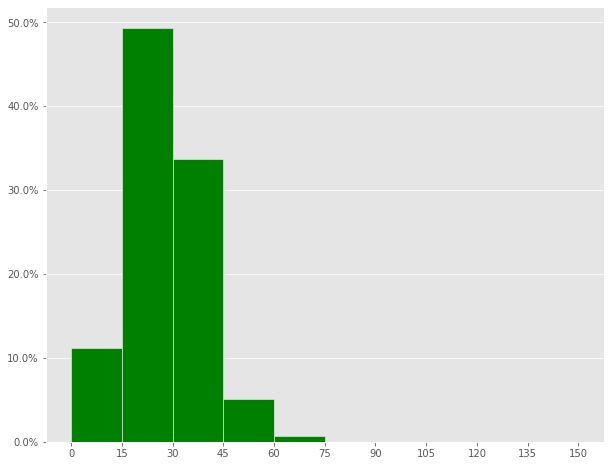

In [6]:
# Select which experiments to plot
EXP = 'G9'
NREP = [1]
NROB = [8]

# Collect data
df = create_df(EXP, 'block')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

# Create figure
bins = range(0,165,15)
xticks = range(0,165,15)

ax = plt.axes()
ax.grid(axis='x', linestyle='--') # vertical lines
ax.set_xticks(xticks) 
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

hist, bins = np.histogram(df['TELAPSED'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='w')

# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

plt.show()

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/42/estimate.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/28/estimate.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/24/estimate.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/66/estimate.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/17/estimate.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/32/estimate.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/44/estimate.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/49/estimate.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/8/estimate.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimatio

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/78/estimate.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/82/estimate.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/3/estimate.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/75/estimate.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/87/estimate.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/19/estimate.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/50/estimate.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/59/estimate.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/80/estimate.csv
24rob-6byz-4
/home/volker/geth-ar

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/89/estimate.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/83/estimate.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/76/estimate.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/20/estimate.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/95/estimate.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/31/estimate.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/45/estimate.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/71/estimate.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/30/estimate.csv
24rob-6byz-8
/home/volker/geth-a

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/17/estimate.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/32/estimate.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/44/estimate.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/49/estimate.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/8/estimate.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/27/estimate.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/51/estimate.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/2/estimate.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/54/estimate.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/78/estimate.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/82/estimate.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/3/estimate.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/75/estimate.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/87/estimate.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/19/estimate.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/50/estimate.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/59/estimate.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/80/estimate.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimatio

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/97/estimate.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/89/estimate.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/83/estimate.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/76/estimate.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/20/estimate.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/95/estimate.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/31/estimate.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/45/estimate.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/71/estimate.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimati

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/15/estimate.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/94/estimate.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/33/estimate.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/42/estimate.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/28/estimate.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/24/estimate.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/66/estimate.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/17/estimate.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/32/estimate.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimati

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/75/estimate.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/87/estimate.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/19/estimate.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/50/estimate.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/59/estimate.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/80/estimate.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/91/estimate.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/6/estimate.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/47/estimate.csv
24rob-6byz-3
/home/volker/geth-ar

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/79/estimate.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/97/estimate.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/89/estimate.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/83/estimate.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/76/estimate.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/20/estimate.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/95/estimate.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/31/estimate.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/45/estimate.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimati

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/28/estimate.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/24/estimate.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/66/estimate.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/17/estimate.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/32/estimate.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/44/estimate.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/49/estimate.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/8/estimate.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/27/estimate.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimatio

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/50/estimate.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/59/estimate.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/80/estimate.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/91/estimate.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/6/estimate.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/47/estimate.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/4/estimate.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/9/estimate.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/73/estimate.csv
8rob-2byz-10
/home/volker/geth-argo

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/31/estimate.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/45/estimate.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/71/estimate.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/30/estimate.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/98/estimate.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/84/estimate.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/37/estimate.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/96/estimate.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/72/estimate.csv
24rob-6byz-7
/home/volker/geth-a

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/36/estimate.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/5/estimate.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/7/estimate.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/48/estimate.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/69/estimate.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/88/estimate.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/46/estimate.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/56/estimate.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/55/estimate.csv
24rob-6byz-10
/ho

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/61/estimate.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/85/estimate.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/90/estimate.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/14/estimate.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/16/estimate.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/74/estimate.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/93/estimate.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/34/estimate.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/43/estimate.csv
24rob-6byz-6
/home/volker/geth-a

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/92/estimate.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/13/estimate.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/18/estimate.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/38/estimate.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/41/estimate.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/21/estimate.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/29/estimate.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/100/estimate.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/63/estimate.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimat

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/65/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/64/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/40/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/36/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/5/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/7/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/48/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/69/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/88/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6b

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/35/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/78/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/82/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/3/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/75/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/87/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/19/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/50/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/59/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/70/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/61/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/85/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/90/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/14/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/16/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/74/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/93/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/34/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/77/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/62/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/79/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/97/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/89/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/83/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/76/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/20/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/95/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/31/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/84/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/37/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/96/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/72/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/86/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/25/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/92/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/13/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/18/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/38/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/92/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/13/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/18/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/38/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/41/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/21/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/29/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/100/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/63/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/1/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/15/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/94/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/33/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/42/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/28/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/24/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/66/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/17/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/32/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/44/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/49/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/8/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/27/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/51/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/2/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/54/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/65/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/64/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/40/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6b

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/46/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/56/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/55/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/99/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/57/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/58/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/68/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/60/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/35/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/78/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/60/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/35/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/78/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/82/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/3/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/75/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/87/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/19/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/50/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/6/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/47/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/4/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/9/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/73/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/26/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/12/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/11/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/23/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/67/sc.csv
8rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/47/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/4/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/9/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/73/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/26/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/12/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/11/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/23/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/67/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2by

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/82/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/3/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/75/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/87/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/19/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/50/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/59/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/80/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/91/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/6/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/47/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/4/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/9/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/73/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/26/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/12/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/11/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/23/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6by

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/34/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/43/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/10/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/81/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/53/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/77/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/62/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/79/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/97/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Ex

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/89/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/83/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/76/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/20/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/95/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/31/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/45/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/71/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/30/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/95/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/31/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/45/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/71/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/30/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/98/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/84/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/37/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/96/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/72/sc.csv
8r

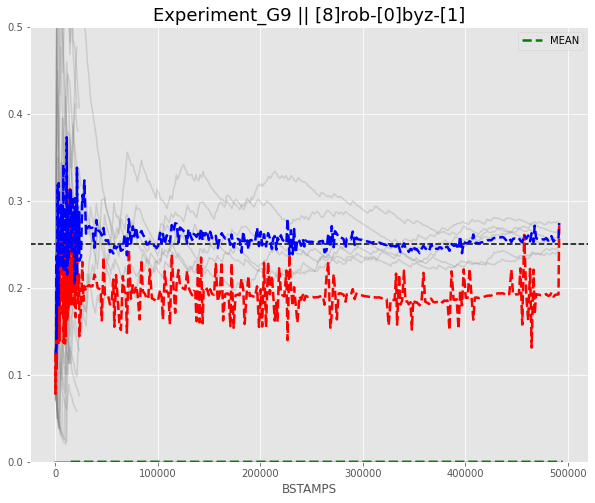

In [7]:
# Select which experiment to plot
EXP = 'G9'
NREP = [1]
NROB = [8]
NBYZ = [0]

# Collect data
df = create_df(EXP, 'estimate')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

# Create figure
ax = plt.axes()

# Plot actual value
handle1 = plt.axhline(0.25, color='k', linestyle='--', linewidth=1.5)
# Plot each robot estimate
handle2 = df.set_index(['TIME']).groupby(['ID'])['ESTIMATE'].plot(color='grey', alpha=0.25)
handle2.label = 'Robot Estimates'
# Plot mean of robot estimates 
handle3 = df[['TIME', 'ESTIMATE']].sort_values('TIME').reset_index().groupby(df.index // NROB).mean().set_index('TIME')['ESTIMATE'].plot(color='r', linestyle='--', linewidth=2.5)
handle3.label = 'Robot Estimates (Mean, incl. Byzantines)'
# Plot excluding Byzantines
handle4 = df[['TIME', 'ESTIMATE']].sort_values('TIME').reset_index().replace(0,np.NaN).groupby(df.index // NROB).mean().set_index('TIME')['ESTIMATE'].plot(color='b', linestyle='--', linewidth=2.5)
handle4.label = 'Robot Estimates (Mean, excl. Byzantines)'

df = create_df(EXP, 'sc')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

df['BSTAMPS'] = df['BLOCK'].mul(15*1000) 
df['MEAN'] = df['MEAN'].div(10000000) 
handle5 = df.groupby(['BLOCK'])[['BSTAMPS', 'MEAN']].max().set_index('BSTAMPS').plot(ax=ax, color='g', linestyle='--', linewidth=2.5)
handle5.label = 'Blockchain Estimate'

# Edit figure looks
ax.set_ylim(ymin=0, ymax=0.5)
ax.set_title('Experiment_{} || {}rob-{}byz-{}'.format(EXP, NROB, NBYZ, NREP), fontsize=18)
# ax.legend()
plt.show()

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/42/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/28/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/24/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/66/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/17/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/32/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/44/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/49/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/8/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/27/sc.csv
8ro

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/51/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/2/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/54/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/65/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/64/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/40/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/36/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/5/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/7/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6by

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/68/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/60/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/35/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/78/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/82/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/3/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/75/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/87/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/19/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/91/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/6/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/47/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/4/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/9/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/73/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/26/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/12/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/11/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6by

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/52/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/70/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/61/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/85/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/90/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/14/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/16/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/74/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/93/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/34/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/10/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/81/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/53/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/77/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/62/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/79/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/97/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/89/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/83/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/76/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/77/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/62/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/79/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/97/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/89/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/83/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/76/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/20/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/95/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/31/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/20/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/95/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/31/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/45/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/71/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/30/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/98/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/84/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/37/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/96/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/98/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/84/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/37/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/96/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/72/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/86/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/25/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/92/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/13/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/18/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/21/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/29/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/100/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/63/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/1/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/39/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/15/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/94/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/33/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/94/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/33/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/42/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/28/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/24/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/66/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/17/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/32/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-5/44/sc.csv
24rob-6byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/51/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/2/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/54/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/65/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/64/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/40/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/36/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/5/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/7/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/48/sc.csv
8rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/40/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/36/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/5/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/7/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/48/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/69/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/88/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/46/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/56/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2by

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/36/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/5/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/7/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/48/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/69/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/88/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/46/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/56/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/55/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6b

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/68/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/60/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/35/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/78/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/82/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/3/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/75/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/87/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/19/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/35/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/78/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/82/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/3/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/75/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/87/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/19/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/50/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/59/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Exp

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/35/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/78/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/82/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/3/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/75/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/87/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/19/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/50/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/59/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/75/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/87/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/19/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/50/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/59/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/80/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/91/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/6/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/47/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/4/sc.csv
8rob

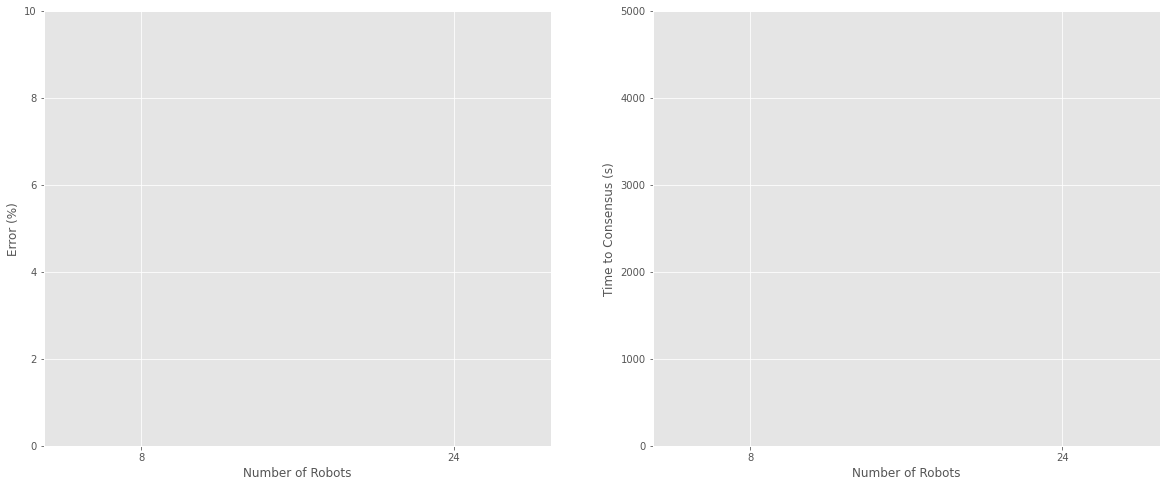

In [10]:
# Select which experiment to plot
EXP = 'G9'
NREP = range(0,15)
NROB = [8,24]

# Collect data
df = create_df(EXP, 'sc')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

# Create figure
fig, ax = plt.subplots(1,2, figsize=(20, 8))

# Big group for each box: Number of robots
boxes = df.groupby('NROB')

for x, box in boxes:
    errors = box.sort_values('TIME').groupby('NREP')['MEAN'].agg(['last']) # not 100% correct yet
    errors = errors.div(10000000).sub(0.25).abs().mul(100)

    cts = box[(box['C?']==True)].sort_values('TIME').groupby('NREP')['TIME'].agg(['first'])
    cts = cts.div(1000)
    
    # Plot boxplots for errors
    ax[0].boxplot(errors['last'], positions=[x/10])
    # Plot boxplots for consensus times
    ax[1].boxplot(cts['first'], positions=[x/10])
    
# Edit figure looks
ax[0].set_ylim(ymin=0, ymax=10)
ax[1].set_ylim(ymin=0, ymax=5000)
ax[0].set_xticklabels(NROB)
ax[1].set_xticklabels(NROB)
ax[0].set_ylabel('Error (%)')
ax[1].set_ylabel('Time to Consensus (s)')
ax[0].set_xlabel('Number of Robots')
ax[1].set_xlabel('Number of Robots')
plt.show()


/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/42/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/28/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/24/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/66/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/17/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/32/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/44/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/49/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/8/sc.csv
8rob-2byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-8/27/sc.csv
8ro

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/2/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/54/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/65/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/64/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/40/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/36/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/5/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/7/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-4/48/sc.csv
24rob-6byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6by

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/35/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/78/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/82/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/3/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/75/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/87/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/19/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/50/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-8/59/sc.csv
24rob-6byz-8
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/12/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/11/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/23/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/67/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/22/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/52/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/70/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/61/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-9/85/sc.csv
24rob-6byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/12/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/11/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/23/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/67/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/22/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/52/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/70/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/61/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/85/sc.csv
8rob-2byz-1
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-1/90/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/22/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/52/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/70/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/61/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/85/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/90/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/14/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/16/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/74/sc.csv
8rob-2byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-6/93/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/14/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/16/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/74/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/93/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/34/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/43/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/10/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/81/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/53/sc.csv
8rob-2byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-2/77/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/93/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/34/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/43/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/10/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/81/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/53/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/77/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/62/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/79/sc.csv
8rob-2byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-7/97/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/62/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/79/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/97/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/89/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/83/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/76/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/20/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/95/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/31/sc.csv
8rob-2byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-3/45/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/37/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/96/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/72/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/86/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/25/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/92/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/13/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/18/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-3/38/sc.csv
24rob-6byz-3
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/41/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/21/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/29/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/100/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/63/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/1/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/39/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/15/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/94/sc.csv
8rob-2byz-9
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-9/33/sc.csv
8r

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/66/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/17/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/32/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/44/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/49/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/8/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/27/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/51/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/2/sc.csv
8rob-2byz-5
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-5/54/sc.csv
8rob

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/54/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/65/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/64/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/40/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/36/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/5/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/7/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/48/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-10/69/sc.csv
8rob-2byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2by

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/56/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/55/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/99/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/57/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/58/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/68/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/60/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/35/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-7/78/sc.csv
24rob-6byz-7
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/99/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/57/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/58/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/68/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/60/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/35/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/78/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/82/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-2/3/sc.csv
24rob-6byz-2
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/4/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/9/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/73/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/26/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/12/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/11/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/23/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/67/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-10/22/sc.csv
24rob-6byz-10
/home/volker/geth-argos/FloorEstimation/results/data/Expe

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/43/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/10/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/81/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/53/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/77/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/62/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/79/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/97/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-6byz-6/89/sc.csv
24rob-6byz-6
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/24rob-

/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/95/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/31/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/45/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/71/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/30/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/98/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/84/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/37/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/96/sc.csv
8rob-2byz-4
/home/volker/geth-argos/FloorEstimation/results/data/Experiment_G9/8rob-2byz-4/72/sc.csv
8r

TypeError: no numeric data to plot

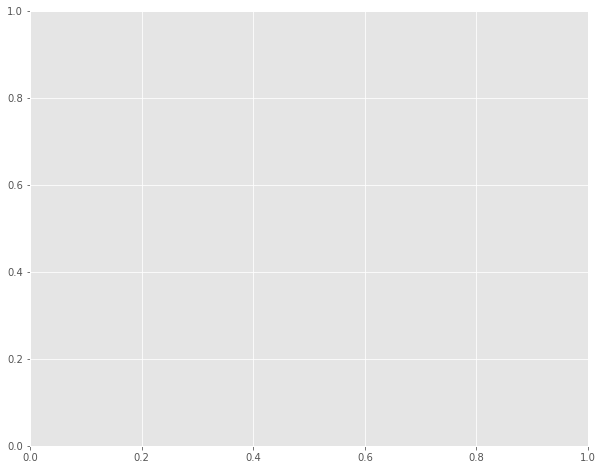

In [9]:
# Select which experiment to plot
EXP = 'G9'
NREP = [0]
NROB = [27]
pd.set_option('display.max_rows', 5000)

# Collect data
df = create_df(EXP, 'sc')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")
# display(df)

# Create figure
ax = plt.axes()

df.set_index(['ID']).groupby(['ID'])['#MYOKVOTES'].agg(['max']).plot.bar(ax=ax, alpha=0.33)

# Collect data
df = create_df(EXP, 'estimate')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

df.set_index(['ID']).groupby(['ID'])['ESTIMATE'].agg(['mean']).plot.bar(ax=ax)

plt.legend(['Number of Votes', 'Estimate (Mean)'])
plt.show()

In [ ]:
from graphviz import Digraph
import pydotplus
import networkx as nx
from networkx.algorithms.shortest_paths.generic import shortest_path as get_mainchain

# Construct digraph
def create_digraph(df):
    # Default settings for blockchain viz
    digraph = Digraph(comment='Blockchain', 
                      edge_attr={'arrowhead':'none'},
                      node_attr={'shape': 'record', 'margin': '0', 'fontsize':'9', 'height':'0.35', 'width':'0.35'}, 
                      graph_attr={'rankdir': 'LR', 'ranksep': '0.1', 'splines':'ortho'})
    

#     df.apply(lambda row : digraph.node(row['HASH'], str(row['BLOCK'])), axis = 1)
    digraph.node(df['PHASH'].iloc[0], '<f0> {} | <f1> {}'.format(df['PHASH'].iloc[0][2:6], 'Genesis'))
    df.apply(lambda row : digraph.node(row['HASH'], '<f0> {} | <f1> {}'.format(row['HASH'][2:6], str(row['BLOCK']))), axis = 1)
    df.apply(lambda row : digraph.edge(row['PHASH'], row['HASH']), axis = 1)
    
    return digraph

def convert_digraph(digraph):
    return nx.nx_pydot.from_pydot(pydotplus.graph_from_dot_data(digraph.source))

# Remove childless blocks
def trim_chain(df, levels=1):
    sub_df = df
    while levels:
        sub_df = sub_df.query('HASH in PHASH')
        levels -= 1
    return sub_df

def paths_longer_than(paths, n):
    return [x for x in paths if len(x)>=n]

def nodes_in_paths(paths):
    return [item for sublist in paths_longer_than(fork_paths, MIN_FORK_LENGTH) for item in sublist]

In [ ]:
# Select which experiment to plot the whole blockchain
tic()
EXP = 'test'
NREP = [0]
NROB = [50]
ID = range(1,100)
# ID=[]

# Collect data
df = create_df(EXP, 'block')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")
df = df.query("ID in @ID")

# display(df)

# Remove duplicate blocks
df = df.drop_duplicates('HASH').sort_values('BLOCK')
genesis = df['PHASH'].iloc[0]

# # df = trim_chain(df, 5)
bc = create_digraph(df)
bc_nx = convert_digraph(bc)
toc()

mainchain_path = get_mainchain(bc_nx, source=genesis, target=str(df['HASH'].iloc[-1]))

# Block hashes which are in mainchain_path -> mainchain 
df_mainchain = df.query("HASH in @mainchain_path")
# Block hashes not in the mainchain_path -> forks
df_forks = df.query("HASH not in @mainchain_path")
forks = create_digraph(df_forks)
forks_nx = convert_digraph(forks)
# Fork block hashes which are not parents -> leafs
df_leafs = df_forks.query('HASH not in PHASH')
# Fork block hashes which are parents but not children -> roots
df_roots = df_forks.query('PHASH not in HASH')
toc()

# bc

In [ ]:
MIN_FORK_LENGTH = 6

fork_paths = [[y] for y in df_leafs['HASH']]
df_roots.apply(lambda row : fork_paths.extend(nx.all_simple_paths(forks_nx, row['HASH'], list(df_leafs['HASH']))), axis = 1)

nodes_in_forks_longer_than = nodes_in_paths(fork_paths)

df_trimmed = df.query('HASH in @nodes_in_forks_longer_than or HASH in @mainchain_path')
bc_trimmed = create_digraph(df_trimmed)

# Do something cool? Idk, for example mainchain in blue or make it bigger
df_trimmed.query('HASH in @mainchain_path').apply(lambda row : bc_trimmed.node(row['HASH'], height='0.7', width='0.7'), axis = 1)
bc_trimmed.node(genesis, height='0.7', width='0.7')

# Do something cool? Idk, for example color blocks sealed by prefered sealer in green. 
df_trimmed.query('DIFF==2').apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='green'), axis = 1)

# Do something cool? Idk, for example try to make mainchain at same level
df_trimmed.query('HASH in @mainchain_path').apply(lambda row : bc_trimmed.node(row['HASH'], group='main'), axis = 1)
bc_trimmed.node(genesis, group='main')

# # Do something cool? Idk, for example try to keep all forks at same level (very slow!)
df_trimmed.query('HASH in @nodes_in_forks_longer_than').apply(lambda row : bc_trimmed.node(row['HASH'], group='forks'), axis = 1)

bc_trimmed
# display(df_trimmed)
# bc_trimmed.render('test-output/blockchain.gv', view=True)